In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt

folder = "../KOI_Data/sample/"

In [2]:
import os

fits_available = os.listdir(folder)
fits_available[:3]

['kplr001025986-20160128150956_dvt.fits',
 'kplr001026032-20160128150956_dvt.fits',
 'kplr001293046-20160128150956_dvt.fits']

In [75]:
hdulist = fits.open(folder+fits_available[6])

hdulist.info()

Filename: ../KOI_Data/sample/kplr001161345-20160128150956_dvt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  TCE_1         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  Statistics    1 BinTableHDU    221   71427R x 50C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In [10]:
hdulist[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   44 / length of first array dimension                
NAXIS2  =                71427 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   10 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [76]:
data = hdulist[1].data

time = data.field('TIME')
lc_init = data.field("LC_INIT")
lc_error = data.field("LC_INIT_ERR")
lc_white = data.field("LC_WHITE")
lc_detrend = data.field("LC_DETREND")
time

array([  131.5127075 ,   131.5331422 ,   131.55357681, ...,  1590.96064215,
        1590.9810767 ,  1591.00151145])

In [72]:
#plot until
p_n = 2000

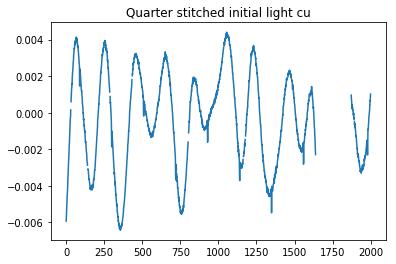

In [185]:
plt.plot(lc_init[:p_n])
plt.title("Quarter stitched initial light cu")
plt.show()

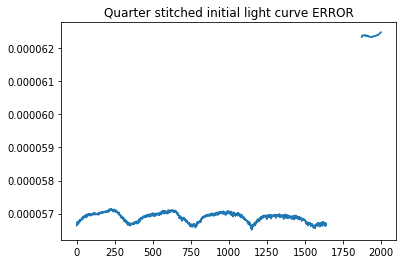

In [186]:
plt.plot(lc_error[:p_n])
plt.title("Quarter stitched initial light curve ERROR")
plt.show()

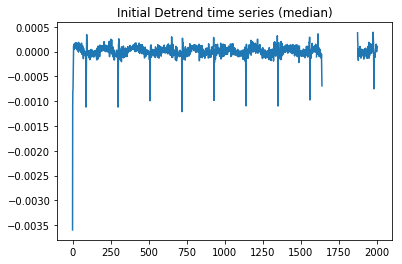

In [78]:
plt.plot(lc_detrend[:p_n])
plt.title("Initial Detrend time series (median)")
plt.show()

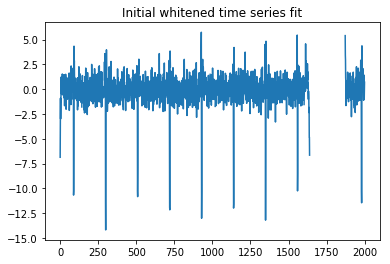

In [81]:
plt.plot(lc_white[:p_n])
plt.title("Initial whitened time series fit")
plt.show()

/home/fmena/anaconda2/envs/py3/lib/python3.5/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


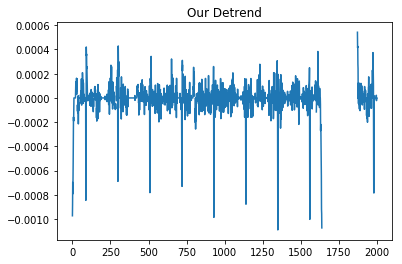

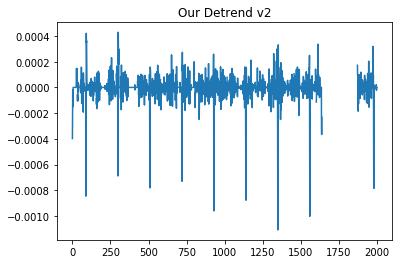

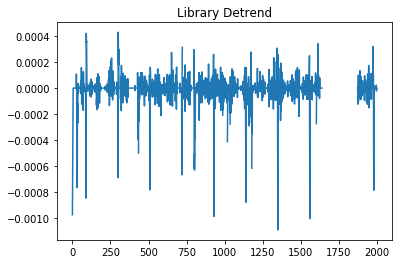

In [86]:
import numpy as np
import matplotlib.pyplot as plt
def detrend_median(values, w=5):
    values = np.asarray(values)
    return_v = values.copy()
    for i in range(values.shape[0]):
        lim_inf = int(    i -(w/2))
        lim_sup = int((i+1) + (w/2))
        if lim_inf <0:
            #lim_sup += np.abs(lim_inf)
            lim_inf = 0
        if lim_sup > values.shape[0]:
            #lim_inf -= (lim_sup-values.shape[0])
            lim_sup = values.shape[0]
        median_filter = np.nanmedian(values[ lim_inf: lim_sup ])
        
        #print("limite inferior: ",lim_inf)
        #print("Valor central: ",i)
        #print("limite superior: ",lim_sup)
        #print(median_filter)
        if not np.isnan(median_filter):
            return_v[i] = values[i] - median_filter
    return return_v
def full_detrend_median(values, w=5):
    f_de = detrend_median(values,w) #forward detrend
    b_de = detrend_median(f_de[::-1],w) #backward detrend
    return b_de[::-1]

our_detrend = detrend_median(lc_init[:], 20) #entre 20 y 25... o 10
our_detrend2 = full_detrend_median(lc_init[:], 10)
plt.plot(our_detrend[:p_n])
plt.title("Our Detrend")
plt.show()

plt.plot(our_detrend2[:p_n])
plt.title("Our Detrend v2")
plt.show()

from scipy.signal import medfilt
med_filt = medfilt(lc_init, kernel_size=11) #with 5 is kepler.. (but 10 seems to be right)
plt.plot(lc_init[:p_n] - med_filt[:p_n])
plt.title("Library Detrend")
plt.show()

In [87]:
from scipy.signal import savgol_filter

def SavGol(y, win=49, return_filter=False):
    '''
    Subtracts a second order Savitsky-Golay filter with window size `win`
    and returns the result. This acts as a high pass filter.
    '''
    if len(y) <= win:
        print("BIG ERROR! short light curve")
        return
    to_return = y.copy()
   
    mask_null = np.isnan(y)
    
    aux_y = y[~mask_null] #saltarse los nans
    #aux_y = np.nan_to_num(y)
    
    
    """ APPLIED FILTER and get residual"""
    filter_savgol = savgol_filter(aux_y, win, 2)
    aux_y = aux_y - filter_savgol + np.nanmedian(aux_y)
      
        
    to_return[~mask_null] = aux_y#[~mask_null]
    to_return[mask_null] = np.nan
    
    if return_filter:
        to_return2 = to_return.copy()
        to_return2[~mask_null] = filter_savgol#[~mask_null]
        to_return2[mask_null] = np.nan
        return to_return, to_return2
    return to_return

In [88]:
lc_SavGol, filter_app = SavGol(lc_detrend, return_filter=True)

[]

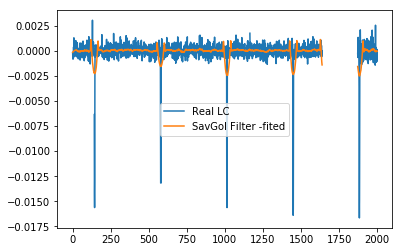

In [60]:
plt.plot(lc_detrend[:p_n], label= "Real LC")
plt.plot(filter_app[:p_n], label= "SavGol Filter -fited")
plt.legend()
plt.plot()

Hola mundo!


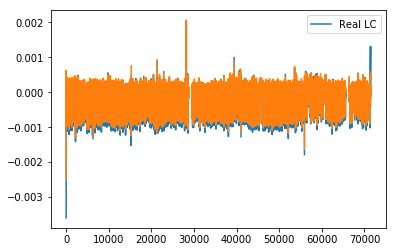

In [90]:
plt.plot(lc_detrend[:], label= "Real LC")
#plt.plot(filter_app[:], label= "SavGol Filter -fited")
plt.plot(lc_SavGol[:]) #saltando "nans"
plt.legend()
plt.plot()
print("Hola mundo!")

In [91]:
def remove_outliers(f, osigma=5, clean_limit=9999):
    '''
    Performs iterative sigma clipping to get outliers.
    '''
    f_clean = f.copy()
    
    do_clean = True
    i=1
    while do_clean and i <= clean_limit:

        # Get the outliers
        f_savgol = SavGol(f_clean)
        #f_savgol = f_clean
        med = np.nanmedian(f_savgol)
        MAD = 1.4826 * np.nanmedian(np.abs(f_savgol - med))
        inds = np.where((f_savgol > med + osigma * MAD) |
                        (f_savgol < med - osigma * MAD))[0]
        #remove outliers
        f_clean[inds] = np.nan
        
        #stop cleaning
        if len(inds) == 0:
            do_clean = False
        i+=1
        print("One clean done, erase %d values"%(len(inds)))
    return f_clean

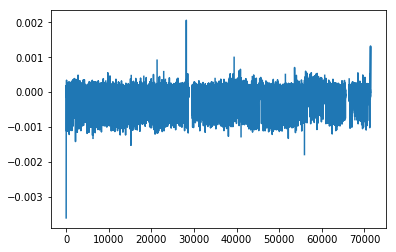

In [92]:
plt.plot(lc_detrend)

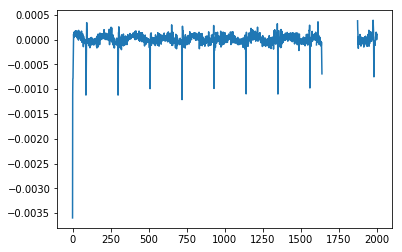

In [93]:
plt.plot(lc_detrend[:p_n])

One clean done, erase 0 values


/home/fmena/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/home/fmena/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less


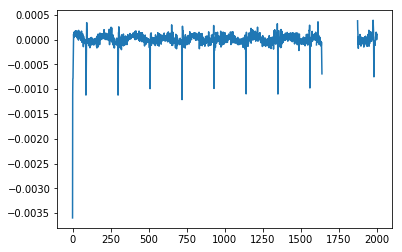

In [98]:
plt.plot(remove_outliers(lc_detrend, 100)[:p_n]) # 5,10-- but i use 100!

In [ ]:
##whitened filter..

In [ ]:
#how to delete positive values??